# Durable Consumption Model

This notebooks shows you how to use the tools of the **consav** package to solve a **durable consumption model** with either

1. **vfi**: standard value function iteration (written in C++)
2. **nvfi**: nested value function iteration (writen in Python, or **nvfi_cpp** is written i C++)
3. **negm**: nested endogenous grid point method (writen in Python, or **negm_cpp** is written i C++)

The implemented solution methods are explained in detail in [A Guide to Solve Non-Convex Consumption-Saving Models](https://drive.google.com/open?id=1V15dwMIrl_TJGoqu7qauhVWcDm0yqb-D).

## Model equations

The **states** are:

1. the persistent component of income, $p_t$
2. stock of the durable good, $n_t$
3. cash-on-hand, $m_t$

The **choices** are:

1. durable consumption, $d_t$
2. non-durable consumption, $c_t$

**Utility** is CRRA over a Cobb-Douglas aggregate:

$$ u(c_{t},d_{t})=\frac{(c_{t}^{\alpha}(d_{t}+\underline{d})^{1-\alpha})^{1-\rho}}{1-\rho} $$

**Income** follows a persistent-transitory process:

$$
\begin{aligned}
p_{t+1}&=\psi_{t+1}p_{t}^{\lambda},\,\,\,\log\psi_{t+1}\sim\mathcal{N}(-0.5\sigma_{\psi}^{2},\sigma_{\psi}^{2}) \\ y_{t+1}&=\xi_{t+1}p_{t+1},\,\,\,\log\xi_{t+1}\sim\mathcal{N}(-0.5\sigma_{\xi}^{2},\sigma_{\xi}^{2})
\end{aligned} 
$$

The household **cannot borrow** and the **interest rate** on savings is $r$. Adjusting the stock of durables is subject to a **proportional adjustment cost** $\tau$ and **durables depreciates** with a rate of $\delta$.

$$ n_{t+1}=(1-\delta)d_{t} $$

The **bellman equation** is

$$
\begin{aligned}
v_{t}(p_{t},n_{t},m_{t})&=\max\{v_{t}^{keep}(p_{t},n_{t},m_{t}),v_{t}^{adj.}(p_{t},x_{t})\}\\&\text{s.t.}&\\x_{t}&=&m_{t}+(1-\tau)n_{t}
\end{aligned} 
$$

 where
 
$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+\beta\mathbb{E}_{t}[v_{t+1}(p_{t+1},n_{t+1},m_{t+1})]\\&\text{s.t.}&\\
a_{t}&= m_{t}-c_{t}\\
m_{t+1}&= (1+r)a_{t}+y_{t+1}\\
n_{t+1}&= (1-\delta)n_{t}\\
a_{t}&\geq 0
\end{aligned} 
$$

and
 
$$
\begin{aligned}
v_{t}^{adj.}(p_{t},x_{t})&= \max_{c_{t},d_{t}}u(c_{t},d_{t})+\beta\mathbb{E}_{t}[v_{t+1}(p_{t+1},n_{t+1},m_{t+1})]\\&\text{s.t.}&\\
a_{t}&= x_{t}-c_{t}-d_{t}\\
m_{t+1}&= (1+r)a_{t}+y_{t+1}\\ 
n_{t+1}&= (1-\delta)n_{t}\\
a_{t}&\geq 0
\end{aligned} 
$$


## Overview

The model solved in this notebook is written in **DurableConsumptionModelModel.py**. 

It provides a class called **DurableConsumptionModelClass** inheriting its basic interface from the **ModelClass**. 

A short **overview** of the interface is:

1. Each instance of the BufferStockModel class must have a **name** and a **solmethod**, and must contain **two central methods**: 
  1. **setup()**: set baseline parameters in `.par` + set list of non-float scalars in `.non_float_list` (for safe type-inference)
  2. **allocate()**: allocate memory for `.par`, `.sol` and `.sim`
2. **Type-inference:** When initializing the model with `BufferStockModelClass()` the `setup()` and `allocate()` methods are called, and the types of all variables in `.par`, `.sol` and `.sim` are inferred. Results can be seen in `.parlist`, `.sollist` and `.simlist` or by `print(model)`.
3. The **solve()** method solves the model
4. The **simulate()** method simulates the model
5. The **save()** method saves the model naming it **data/name_solmethod**
6. The **copy()** makes a deep copy of the model

In addition to **DurableConsumptionModel.py**, this folder contains the following files:

1. **last_period.py**: calculate consumption and value function in last period
2. **utility.py**: utility function and marginal utility function
3. **trans.py**: state transition functions
4. **post_decision.py**: calcualte $w$ and $q$
5. **nvfi.py**: solve with nested value function iteration
6. **negm.py**: solve with the nested endogenous grid method
7. **simulate.py**: simulate for all solution methods
8. **figs.py**: plot figures
9. **tabs.py**: prints tables in .tex files

The functions in these modules are loaded in **DurableConsumptionModel.py**.

The folder **cppfuncs** contains C++ functions used for solving with **vfi**, **nvfi_cpp** or **negm_cpp**.

## Numba

Before (important!) you load **Numba** you can disable it or choose the numbe of threads as follows:

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=8)

# Setup

In [2]:
import time
import numpy as np

%matplotlib inline

# reload module each time cell is run
%load_ext autoreload
%autoreload 2

# load the BufferStockModel module
from DurableConsumptionModel import DurableConsumptionModelClass

Choose number of periods to solve:

In [3]:
T = 5

# NVFI - nested value function iteration

Define the **post-decision value function** as

$$ w_{t}(p_{t},n_{t},a_{t}) = \beta \mathbb{E}_{t}[v_{t+1}(m_{t+1},n_{t+1},p_{t+1})] $$

The **keeper problem** can then be written:

$$
\begin{aligned}
v_{t}^{keep}(p_{t},n_{t},m_{t})&=\max_{c_{t}}u(c_{t},n_{t})+ w_{t}(p_{t},n_{t},a_{t})]\\&\text{s.t.}&\\a_{t}&=&m_{t}-c_{t}\geq0
\end{aligned}
$$

The **adjuster problem** can further be written:

$$
\begin{aligned}
v_{t}^{adj.}(x_{t})&=\max_{d_{t}}v_{t}^{keep}(p_{t},d_{t},n_{t})\\&\text{s.t.}&\\m_{t}&=&x_{t}-d_{t}
\end{aligned}
$$

**NVFI** solves this reformulated problem.

In [4]:
model_nvfi = DurableConsumptionModelClass(name='example',solmethod='nvfi',T=T,do_print=True)
print(model_nvfi)

Modelclass: DurableConsumptionModelClass

Parameters:
 do_2d = False
 T = 5 [int64]
 beta = 0.965 [float64]
 rho = 2.0 [float64]
 alpha = 0.9 [float64]
 d_ubar = 0.01 [float64]
 d1_ubar = 0.01 [float64]
 d2_ubar = 0.01 [float64]
 R = 1.03 [float64]
 tau = 0.1 [float64]
 tau1 = 0.08 [float64]
 tau2 = 0.12 [float64]
 delta = 0.15 [float64]
 delta1 = 0.1 [float64]
 delta2 = 0.2 [float64]
 gamma = 0.5 [float64]
 sigma_psi = 0.1 [float64]
 Npsi = 5 [int64]
 sigma_xi = 0.1 [float64]
 Nxi = 5 [int64]
 pi = 0.0 [float64]
 mu = 0.5 [float64]
 Np = 50 [int64]
 p_min = 0.0001 [float64]
 p_max = 3.0 [float64]
 Nn = 50 [int64]
 n_max = 3.0 [float64]
 Nm = 100 [int64]
 m_max = 10.0 [float64]
 Nx = 100 [int64]
 x_max = 13.0 [float64]
 Na = 100 [int64]
 a_max = 11.0 [float64]
 sigma_p0 = 0.2 [float64]
 mu_d0 = 0.8 [float64]
 sigma_d0 = 0.2 [float64]
 mu_a0 = 0.2 [float64]
 sigma_a0 = 0.1 [float64]
 simN = 100000 [int64]
 sim_seed = 1998 [int64]
 euler_cutoff = 0.02 [float64]
 t = 0 [int64]
 tol = 1e-0

In [5]:
model_nvfi.precompile_numba() # solve with very coarse grids
model_nvfi.solve()
model_nvfi.simulate()
model_nvfi.save()

**Plot** interactive decision functions:

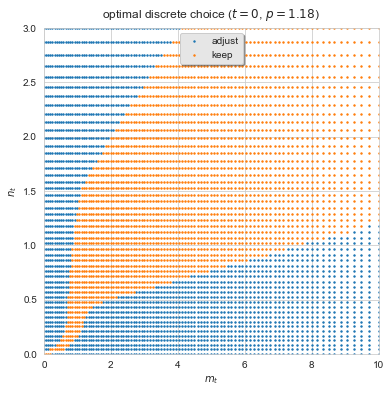

In [6]:
model_nvfi.decision_functions()

**Plot** life-cycle profiles:

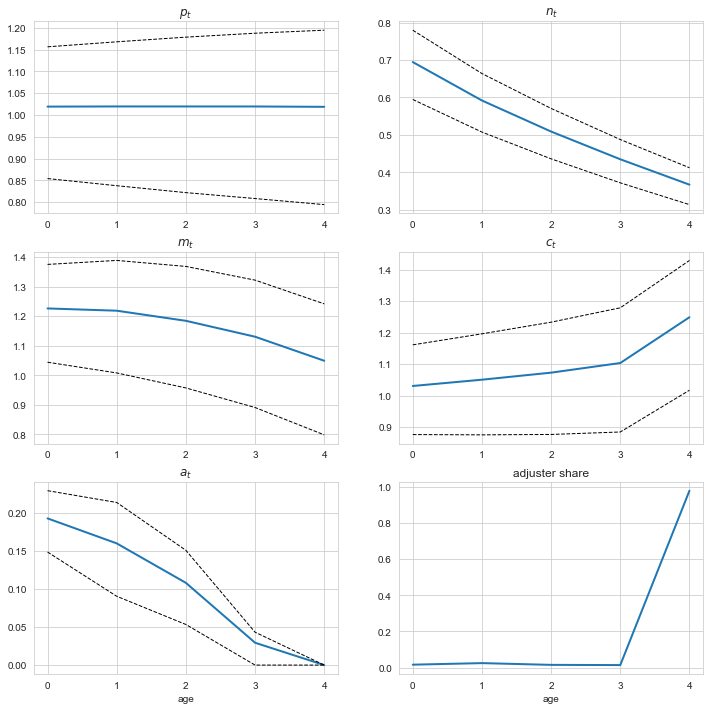

In [7]:
model_nvfi.lifecycle()

# NEGM - nested endogenous grid method

Define the **post-decision marginal value of cash:**

$$
\begin{aligned}
q_{t}(p_{t},d_{t},a_{t})&=\beta R\mathbb{E}_{t}[u_{c}(c_{t+1},d_{t+1})]\\
&=&\beta R\mathbb{E}_{t}[\alpha c_{t+1}^{\alpha(1-\rho)-1}d_{t+1}^{(1-\alpha)(1-\rho)}]
\end{aligned}
$$

Note that all optimal interior consumption choices must satisfy the **Euler-equation**

$$
\begin{aligned}
u_{c}(c_{t},d_{t})=\alpha c_{t}^{\alpha(1-\rho)-1}d_{t}^{(1-\alpha)(1-\rho)}&=q(p_{t},d_{t},a_{t})
\end{aligned}
$$

This implies that we have an analytical mapping from the post-decision space $(p_t,d_t,a_t)$ to consumption and cash-on-hand $(c_t,m_t)$:

$$
\begin{aligned}
c_{t} &=\frac{1}{\alpha}\left(\frac{q(a_{t},d_{t},p_{t})}{d_{t}^{(1-\alpha)(1-\rho)}}\right)^{\alpha(1-\rho)-1}
\\
m_{t} &= a_{t}+c_{t}
\end{aligned}
$$

**NEGM** uses this mapping (and an upperenvelope algorithm) to solve the keeper problem much faster.

In [8]:
model_negm = DurableConsumptionModelClass(name='example',solmethod='negm',T=T,do_print=True)
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()
model_negm.simulate()
model_negm.save()

**Plot** interactive decision functions:

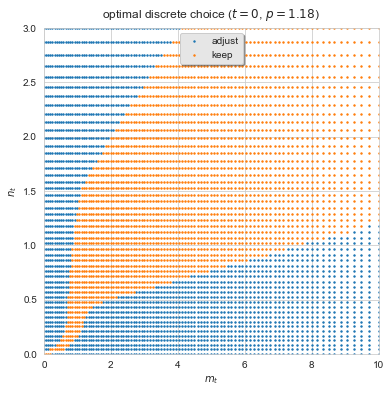

In [9]:
model_negm.decision_functions()

**Plot** life-cycle profiles:

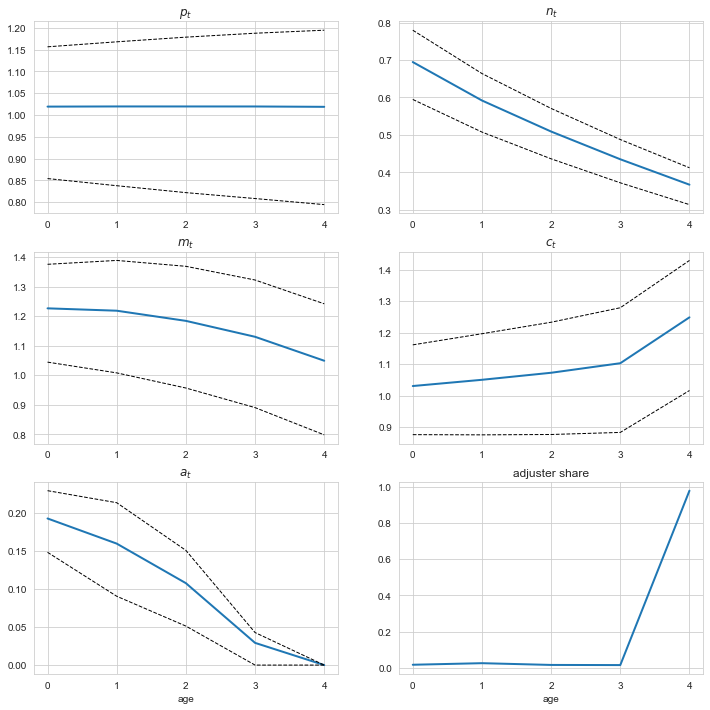

In [10]:
model_negm.lifecycle()

# Compare life-cycles from NVFI and NEGM

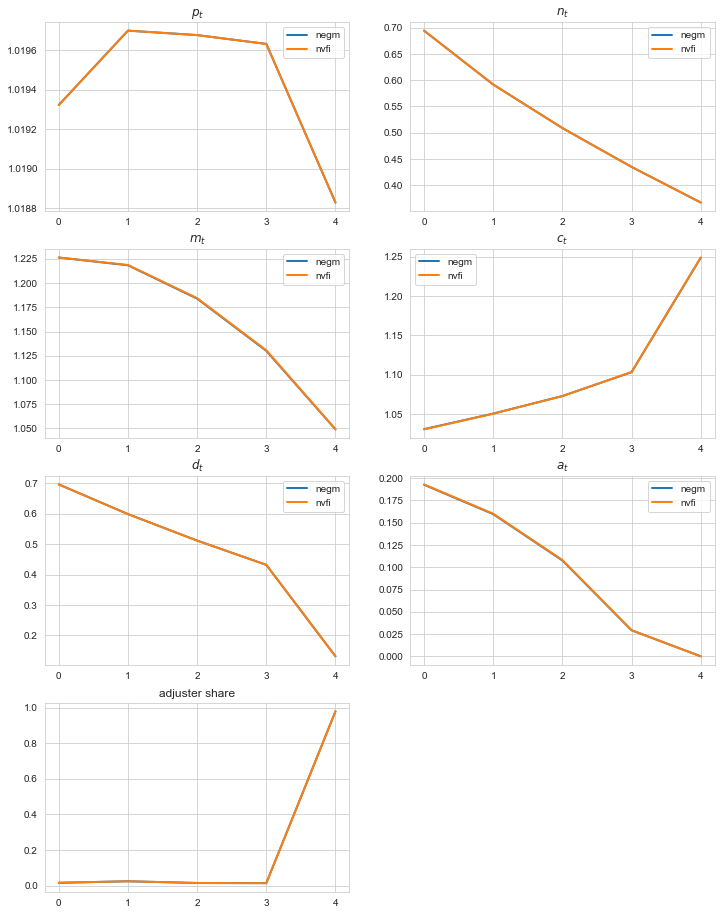

In [11]:
from figs import lifecycle_compare
lifecycle_compare(model_negm,'negm',model_nvfi,'nvfi')

# Compare life-cycle profiles with VFI

In [12]:
model_vfi = DurableConsumptionModelClass(name='example',solmethod='vfi',T=T,do_print=True) 
model_vfi.precompile_numba() # solve with very coarse grids
model_vfi.solve()
model_vfi.simulate()
model_vfi.save()

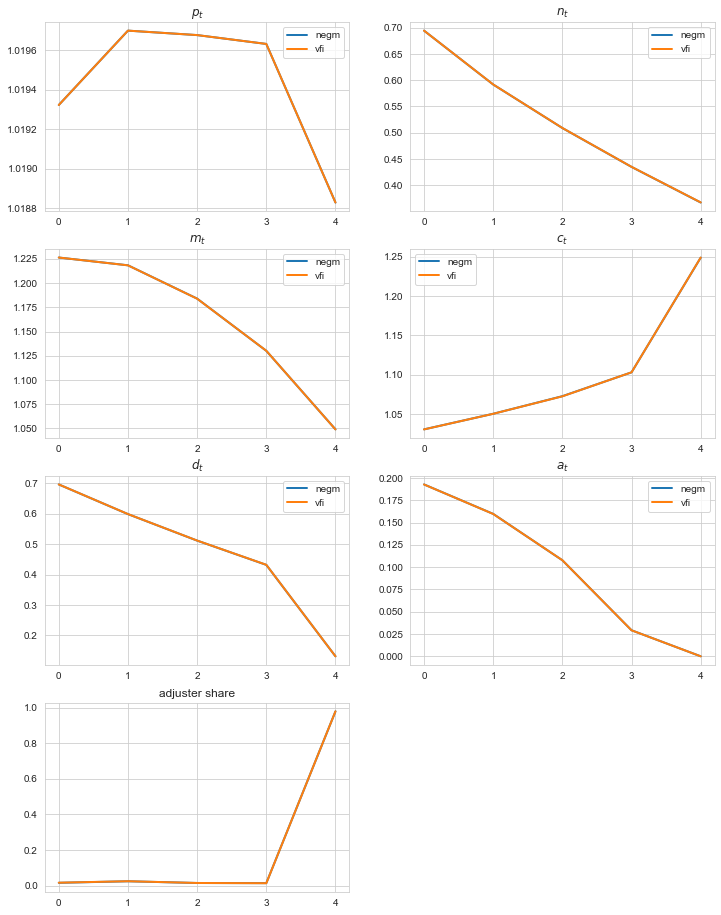

In [13]:
lifecycle_compare(model_negm,'negm',model_vfi,'vfi')